# Carga de dataset personalizado para segmentación

Además de los datasets de Torchvision, PyTorch proporciona herramientas para la carga de datasets personalizados. Para ello, crearemos una clase que herede de [Dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets) y sobreescribiremos los métodos [`__len__()`](https://docs.python.org/3.7/reference/datamodel.html#object.__len__) y [`__getitem__()`](https://docs.python.org/3.7/reference/datamodel.html#object.__getitem__). 

En este caso crearemos un dataset personalizado para la segmentación a partir del dataset [__[Mouse Embryos](https://bbbc.broadinstitute.org/BBBC003)__], que contiene un conjunto de 15 imágenes con sus respectivas máscaras de segmentación manuales.

In [1]:
import torch.utils.data as data
from torchvision.io import read_image
import torchvision.transforms as transforms
import glob
import os


class EmbryoDataset(data.Dataset):
    
    def __init__(self, image_path, mask_path, transform = None):
        super().__init__()
        # Load all the filenames with extension jpg from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path, '*.jpg'))
        self.mask_files = []    
                
        # Load the filenames of the masks (it is assumed that each mask
        # has the same name as the corresponding image).
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path,os.path.basename(img_path)))
                
        if transform:
          self.transform = transform
        else:
          self.transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.ToTensor()])


    # Returns the n-th image with its corresponding mask and image name
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        # Get label from imagename
        name = os.path.splitext(os.path.basename(img_path))[0]

        # Get image and mask
        image = read_image(img_path)
        image = self.transform(image)

        mask = read_image(mask_path)
        mask = self.transform(mask)

        return image, mask, name

    def __len__(self):
        return len(self.img_files)

Funciones auxiliares para convertir un tensor de torch en una matriz numpy y la visualización de una imagen con su máscara.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image

def show(image, mask, title=None):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.show()

Carga de dataset sin data augmentation

15


/tmp/ipykernel_15336/360545178.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  new_image[:,:] = tensor[0,:,:]


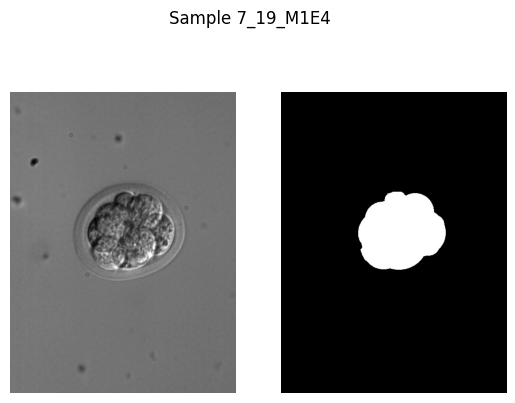

In [4]:
route = '/home/clown/2-semester/vision_individual/'

         
simple_dataset = EmbryoDataset(f"{route}/Embryo/images", f"{route}/Embryo/masks")
print(len(simple_dataset))

# Visualize a sample
image, mask, name = simple_dataset[0]
show(tensor_to_image(image), tensor_to_image(mask), title=f"Sample {name}")



Carga de dataset con data augmentation

/tmp/ipykernel_15336/360545178.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  new_image[:,:] = tensor[0,:,:]


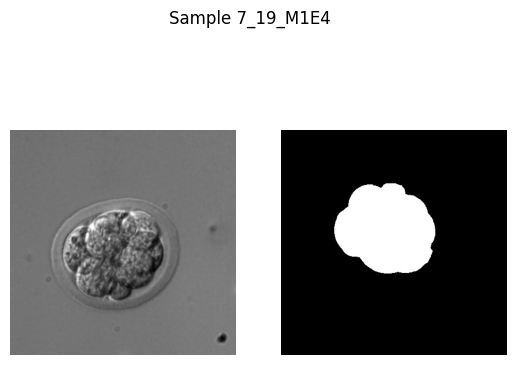

In [5]:
aug_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5),
    transforms.CenterCrop(416),
    transforms.ToTensor()
])

aug_dataset = EmbryoDataset(f"{route}/Embryo/images", f"{route}/Embryo/masks", aug_transforms)


# Visualize a sample
image, mask, name = aug_dataset[0]
show(tensor_to_image(image), tensor_to_image(mask), title=f"Sample {name}")

División del conjunto de datos en entrenamiento y test 

In [8]:
import torch

TEST_RATIO = 0.2
BATCH_SIZE = 1

num_train = int((1.0 - TEST_RATIO) * len(simple_dataset))
num_test = len(simple_dataset) - num_train

torch.manual_seed(42)
train_set, test_set = torch.utils.data.random_split(simple_dataset, [num_train, num_test])

# Loader for train and validation sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=8)

print("Total: ", len(simple_dataset), "| Train: ", len(train_loader), "| Test: ", len(test_loader))

Total:  15 | Train:  12 | Test:  3
